In [1]:
import sys 
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2
import os

In [3]:
from utils.dataLoader_XR import LandmarksDataset, ToTensor, Rescale
from torchvision import transforms

test_path = "../Datasets/JSRT_Padchest/Test"

img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'Landmarks')
sdf_path = os.path.join(test_path, 'SDF')
mask_path = os.path.join(test_path, 'Masks')
test_dataset = LandmarksDataset(img_path=img_path,
                                mask_path=mask_path,
                                sdf_path = sdf_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale(1024),
                                             ToTensor()])
                                 )

test_ids = [t.split('/')[-1].split('.')[0] for t in test_dataset.masks]
len(test_ids)

58

In [4]:
# median model for qualitative analysis
median = {'UNet': 2, 'UNet_Joint': 2, 'Rasterize': 3 , 'HybridGNet': 3 , 'HybridGNet_IGSC': 2 , 'Joint_HCD': 1 , 'Joint': 2, 'HCD': 1}

In [5]:
# load scores for model 
UNet_scores = pd.read_pickle('JSRT_Padchest/Scores/UNet_scores.pkl')
UNet_scores = UNet_scores.loc[UNet_scores['Model'] == 'UNet_'+str(median['UNet'])]
UNet_scores['ID'] = test_ids
UNet_scores.sort_values('ID', ascending=True)

UNet_Joint_scores = pd.read_pickle('JSRT_Padchest/Scores/UNet_Joint_scores.pkl')
UNet_Joint_scores = UNet_Joint_scores.loc[UNet_Joint_scores['Model'] == 'UNet_Joint_'+str(median['UNet_Joint'])]
UNet_Joint_scores['ID'] = test_ids
UNet_Joint_scores.sort_values('ID', ascending=True)

Rasterize_scores = pd.read_pickle('JSRT_Padchest/Scores/Rasterize_scores.pkl')
Rasterize_scores = Rasterize_scores.loc[Rasterize_scores['Model'] == 'Rasterize_'+str(median['Rasterize'])]
Rasterize_scores['ID'] = test_ids
Rasterize_scores.sort_values('ID', ascending=True)

HybridGNet_scores = pd.read_pickle('JSRT_Padchest/Scores/HybridGNet_scores.pkl')
HybridGNet_scores = HybridGNet_scores.loc[HybridGNet_scores['Model'] == 'HybridGNet_'+str(median['HybridGNet'])]
HybridGNet_scores['ID'] = test_ids
HybridGNet_scores.sort_values('ID', ascending=True)

HybridGNet_IGSC_scores = pd.read_pickle('JSRT_Padchest/Scores/HybridGNet_IGSC_scores.pkl')
HybridGNet_IGSC_scores = HybridGNet_IGSC_scores.loc[HybridGNet_IGSC_scores['Model'] == 'HybridGNet_IGSC_'+str(median['HybridGNet_IGSC'])]
HybridGNet_IGSC_scores['ID'] = test_ids
HybridGNet_IGSC_scores.sort_values('ID', ascending=True)

Joint_HCD_scores = pd.read_pickle('JSRT_Padchest/Scores/Joint_HCD_scores.pkl')
Joint_HCD_scores = Joint_HCD_scores.loc[Joint_HCD_scores['Model'] == 'Joint_HCD_'+str(median['Joint_HCD'])]
Joint_HCD_scores['ID'] = test_ids
Joint_HCD_scores.sort_values('ID', ascending=True)

Joint_scores = pd.read_pickle('JSRT_Padchest/Scores/Joint_scores.pkl')
Joint_scores = Joint_scores.loc[Joint_scores['Model'] == 'Joint_'+str(median['Joint'])]
Joint_scores['ID'] = test_ids
Joint_scores.sort_values('ID', ascending=True)

HCD_scores = pd.read_pickle('JSRT_Padchest/Scores/HCD_scores.pkl')
HCD_scores = HCD_scores.loc[HCD_scores['Model'] == 'HCD_'+str(median['HCD'])]
HCD_scores['ID'] = test_ids
HCD_scores.sort_values('ID', ascending=True)

print('Loaded all results')

Loaded all results


In [6]:
len(UNet_scores), len(UNet_Joint_scores), len(Rasterize_scores), len(HybridGNet_scores), len(HybridGNet_IGSC_scores), len(Joint_HCD_scores), len(Joint_scores), len(HCD_scores)

(58, 58, 58, 58, 58, 58, 58, 58)

In [7]:
all_results = pd.concat([UNet_scores, UNet_Joint_scores, Rasterize_scores, HybridGNet_scores, HybridGNet_IGSC_scores, Joint_scores, HCD_scores, Joint_HCD_scores])

In [10]:
def load_preds(model_name, examples, gt):
    pred_all = []
    for i in range(len(examples)):
        pred = np.load(sorted(glob.glob('JSRT_Padchest/Predictions/'+model_name+'/'+str(median[model_name])+'/*.npy'))[examples[i]])
        pred = colour_organ(pred)
        pred_all.append(pred)
    return pred_all

def colour_organ(pred):
    lungs = np.tile(np.expand_dims(pred == 1, -1), [1,1,3]) * lungs_colour
    heart = np.tile(np.expand_dims(pred == 2, -1), [1,1,3]) * heart_colour
    return lungs + heart


In [11]:
lungs_colour = np.stack([np.full((1024, 1024), colour) for colour in [41, 113, 207]], axis=-1)
heart_colour = np.stack([np.full((1024, 1024), colour) for colour in [245, 43, 39]], axis=-1)

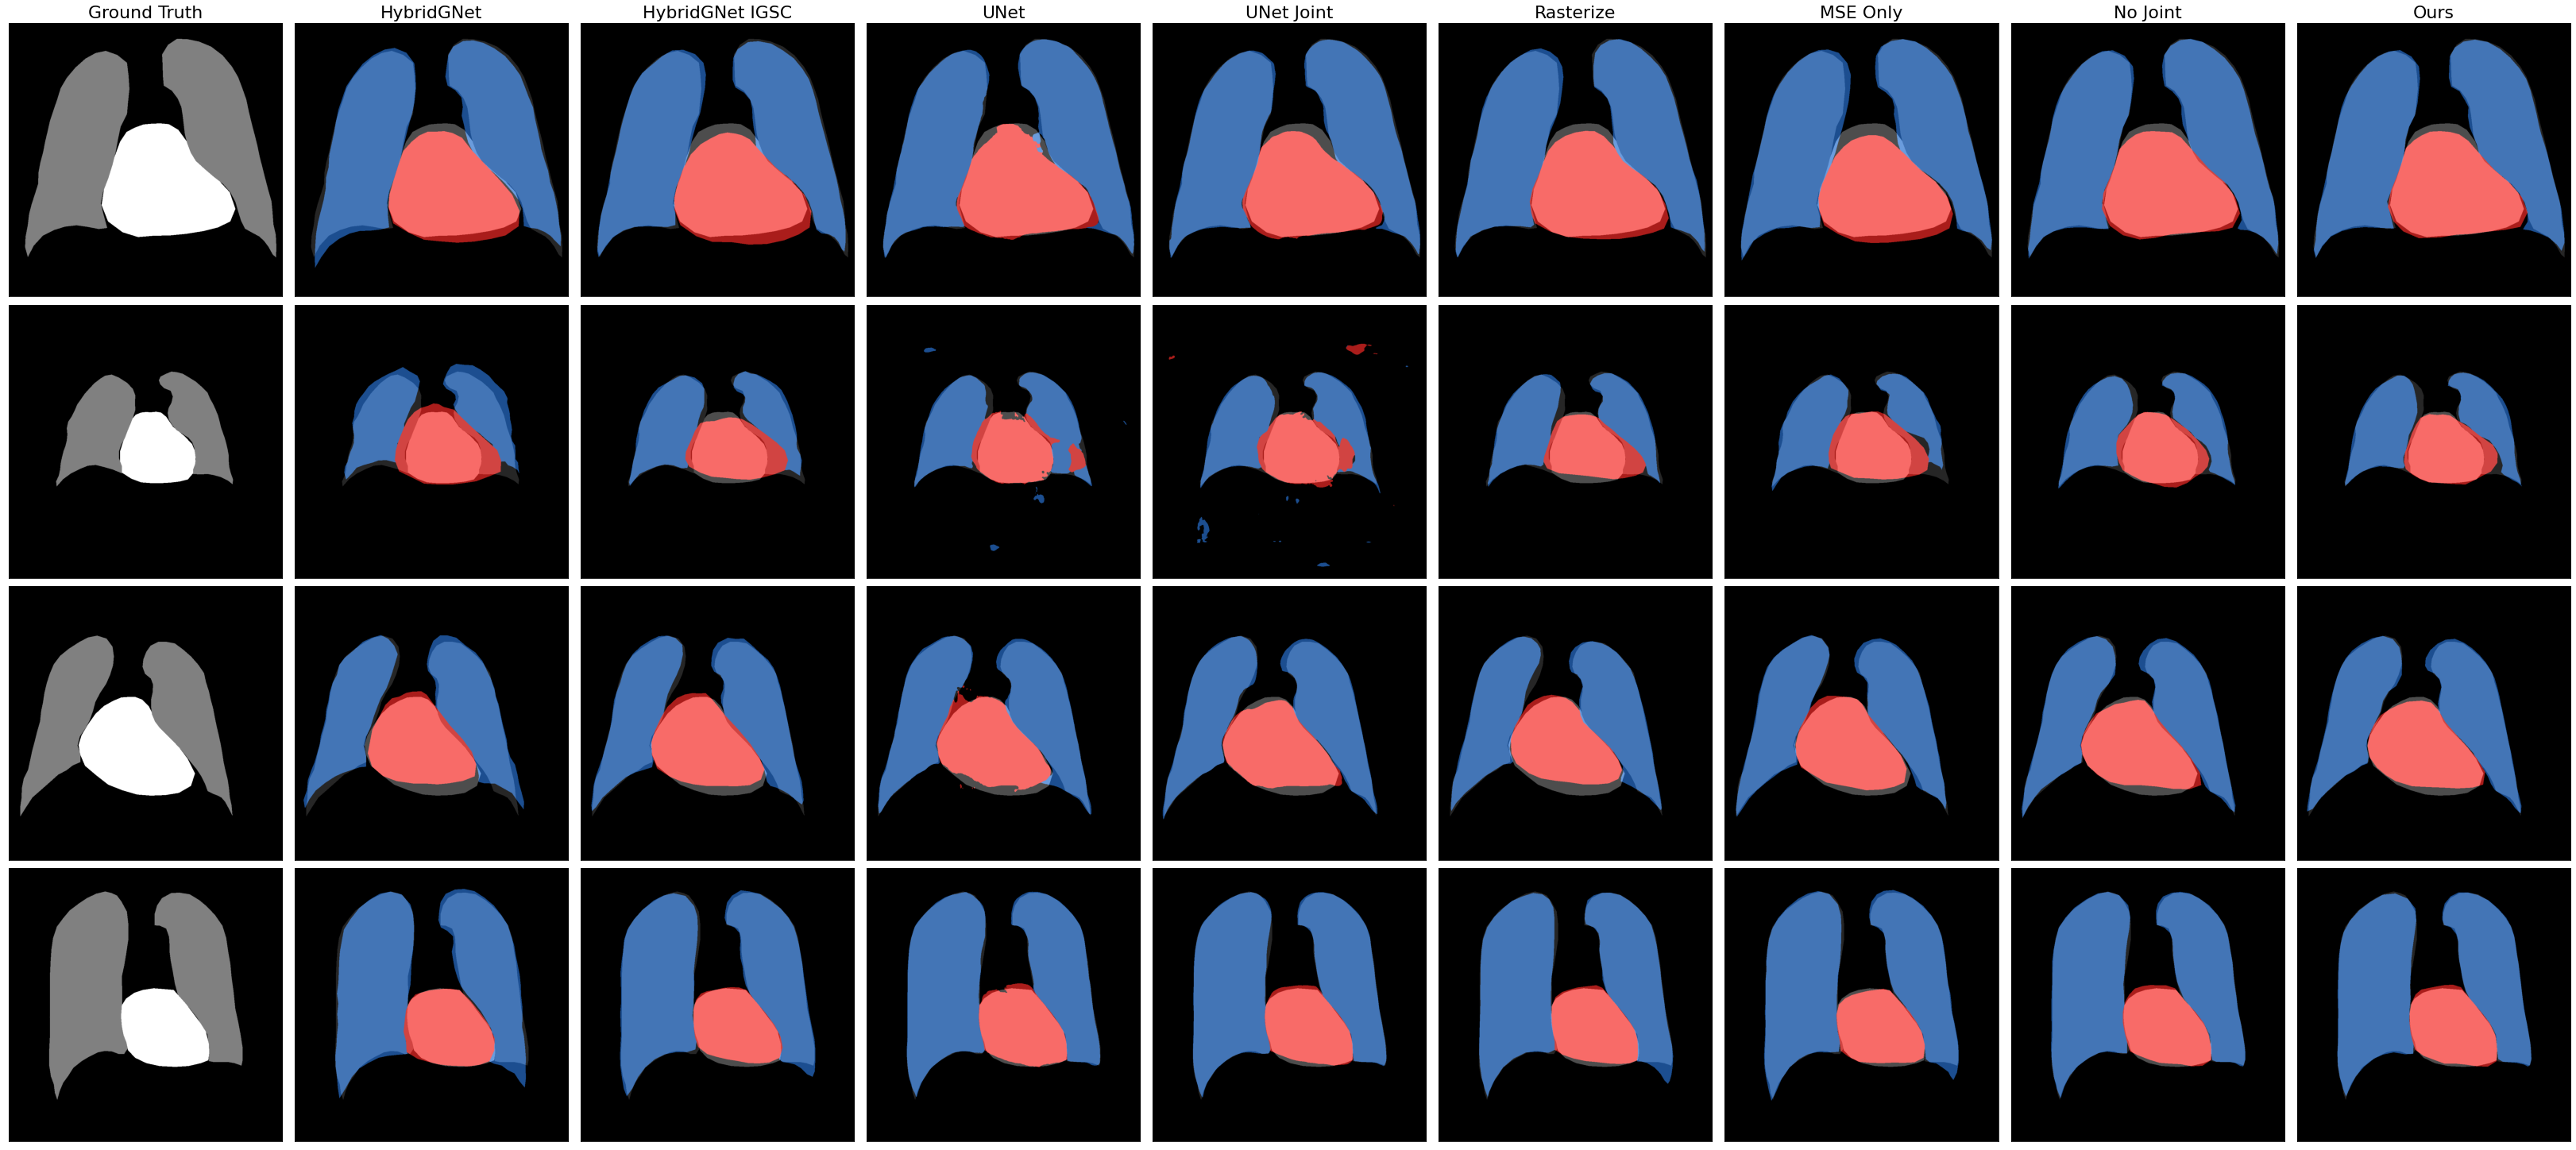

In [12]:
examples = [9,5,12,47] 

columns = ['Ground Truth', 'HybridGNet', 'HybridGNet IGSC', 'UNet', 'UNet Joint', 'Rasterize', 'MSE Only', 'No Joint', 'Ours']
alpha = .7

images = [cv2.imread(sorted(glob.glob('../Datasets/JSRT_Padchest/Test/Images/*.png'))[examples[i]], cv2.IMREAD_GRAYSCALE) for i in range(len(examples))]
gt = [np.load(sorted(glob.glob('../Datasets/JSRT_Padchest/Test/Masks/*.npy'))[examples[i]]) for i in range(len(examples))]

HybridGNet_preds = load_preds('HybridGNet', examples, gt)
HybridGNet_IGSC_preds = load_preds('HybridGNet_IGSC', examples, gt)
UNet_preds = load_preds('UNet', examples, gt)
UNet_Joint_preds = load_preds('UNet_Joint', examples, gt)
Rasterize_preds = load_preds('Rasterize', examples, gt)
Joint_HCD_preds = load_preds('Joint_HCD', examples, gt)
Joint_preds = load_preds('Joint', examples, gt)
HCD_preds = load_preds('HCD', examples, gt)

# 9 columsn, 4 rows. each subplot has gt + pred
fig, axes = plt.subplots(len(examples),9, figsize=(45, 20), constrained_layout=True)

for i in range(len(examples)):
    for j in range(9):
        gti = gt[i]
        axes[i,j].imshow(gti, cmap='gray')
        
    axes[i,0].imshow(gt[i], cmap='gray')    
    axes[i,1].imshow(HybridGNet_preds[i], alpha=alpha)
    axes[i,2].imshow(HybridGNet_IGSC_preds[i], alpha=alpha)
    axes[i,3].imshow(UNet_preds[i], alpha=alpha)
    axes[i,4].imshow(UNet_Joint_preds[i], alpha=alpha)
    axes[i,5].imshow(Rasterize_preds[i], alpha=alpha)
    axes[i,6].imshow(HCD_preds[i], alpha=alpha)
    axes[i,7].imshow(Joint_preds[i], alpha=alpha)
    axes[i,8].imshow(Joint_HCD_preds[i], alpha=alpha)

for i in range(9):
    axes[0, i].set_title(columns[i], size=22)
        
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    
#plt.savefig('Graphics/QUALITATIVE.png', dpi=300)
    
    